In [ ]:
%pip install lime

In [ ]:
%pip install opencv-python==4.6.0.66

In [1]:
import tensorflow as tf
from lime import lime_image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pathlib

2023-04-17 16:03:33.970079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 16:03:34.001413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 16:03:34.501894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ai-05/Desktop/sdp/cpuonly/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm a

In [ ]:
model

In [11]:
tf.get_logger().setLevel('ERROR')
def explainer(img_path="dcrpi-167/Plastic/2023-03-21 16_40_56.589453.png",
              model_path='Tuner/ResNet50-STBv1.0_18_p/03.h5',
              num_samples=1000):
    print("reading image file")
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    image = image
    print("loading model")
    model = tf.keras.models.load_model(model_path)
    print(image.shape)
    image=tf.expand_dims(image,axis=0)
    image=tf.cast(image,tf.float32)

    print(model.predict(image))
    print("starting limeing:)")
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image.astype('double'), model.predict,  
                                            top_labels=3, hide_color=0, num_samples=num_samples)

    return explanation, image

In [12]:
explanation, image = explainer(img_path="coke.jpeg",num_samples=1000)

reading image file
loading model
(224, 224, 3)
1/1 [==============================] - 1s 812ms/step
[[9.9952817e-01 2.0415460e-05 4.5149663e-04]]
starting limeing:)


AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

: 

In [4]:
def visualize_explainer(explanation, image,num_features):
    temp = [0,0]
    mask = [0,0]
    temp[0], mask[0] = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
    temp[1], mask[1] = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,negative_only=True, num_features=num_features, hide_rest=True)

    from skimage.segmentation import mark_boundaries
    # print("visualizing")
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    for i in range(2):
        ax = plt.subplot(1, 3, i+2)
        plt.imshow(mark_boundaries(temp[i], mask[i]).astype("uint8"))
        plt.axis("off") 

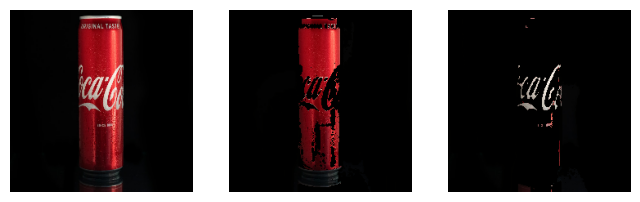

In [5]:
visualize_explainer(explanation, image,35)

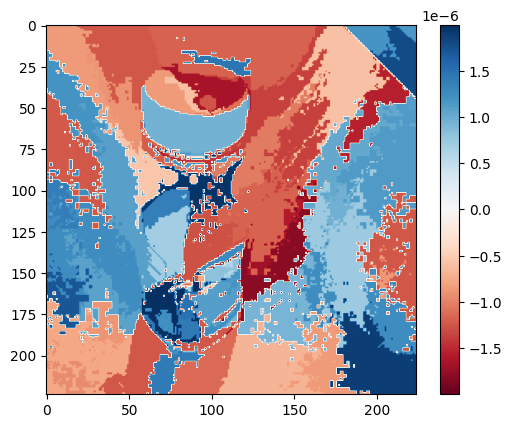

In [10]:
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()